## Setup

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import sys

sys.path.append('../')
from models.model3 import model3
from train import train, dataset_token, custom_collate, plot_losses, tokenizer, train_steps

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
torch.cuda.set_per_process_memory_fraction(0.9)

Usando dispositivo: cuda


In [2]:
# cargamos los datos 100k
data = pd.read_csv('../../data/es-es_LF_100k.txt', sep='\t', header=None, on_bad_lines='skip')
filtered_vocab = np.load('../../data/sub_vocab.npy').tolist()
data.columns = ['spanish', 'lunfardo']
data.head()

,spanish,lunfardo
0,las compañías que los venden afirman que son u...,los vivos que los largan aseguran que son un m...
1,academias y escuelas en quart de poblet página...,los colegios y las escuelas en quart de poblet...
2,existen varias áreas recreativas como la del m...,"hay varios chongos para reventar la tarde, com..."
3,moldeo por inyección de plástico,meterle el plástico a presión
4,"el equipo descendió a segunda división, quedan...","el cuadro se fue al tacho a la b, quedando emp..."


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data['spanish'], data['lunfardo'],
                                                  test_size=0.05, random_state=28)

train_dataset = dataset_token(X_train, y_train)
val_dataset = dataset_token(X_val, y_val)

print('Primer elemento del dataset de validación:', val_dataset[3])

Primer elemento del dataset de validación: {'input': tensor([  101, 18470, 11246, 10126, 10153, 13653, 12867, 29637, 10126, 10305,
        11129, 10102, 11499, 89348, 10117, 16901,   119,   102],
       device='cuda:0'), 'target': tensor([  101, 10525, 28083, 10126, 10153, 10106, 24847, 29637, 10126, 17322,
        17368, 10102, 11499, 89348, 10106, 25930,   119,   102],
       device='cuda:0'), 'input_length': tensor(18, device='cuda:0'), 'target_length': tensor(18, device='cuda:0')}


In [4]:
def generate_target(model, dataset, IDX):
    input_IDX = dataset[IDX]['input']
    target_IDX = dataset[IDX]['target']
    target_pred_IDX = model.generate(input_IDX)
    print(tokenizer.decode(input_IDX))
    print(tokenizer.decode(target_IDX))
    print(tokenizer.decode(target_pred_IDX))

## Configuration 1
Tiene que poder memorizar 10 muestras para empezar

In [5]:
# Inicializa el modelo 
model = model3(
    name = 'transformer_plus_filt_vocab',
    filtered_vocab=filtered_vocab,
    d_model=512//2,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=1024
).to(device)

print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 8297745 parámetros


In [13]:
BATCH_SIZE = 10
MAX_STEPS = 500
LR = 1e-3

data_overfit = data.head(BATCH_SIZE)
dataset_overfit = dataset_token(data_overfit['spanish'], data_overfit['lunfardo'])
loader_overfit = DataLoader(dataset_overfit, batch_size=BATCH_SIZE, collate_fn=custom_collate)
train_loss, val_loss = train_steps(model, loader_overfit, max_steps=MAX_STEPS, lr=LR, verbose_each=5)

Iniciando entrenamiento...
--------------------------------------------------
Entrenamiento completado! Tiempo total: 0.42 minutos


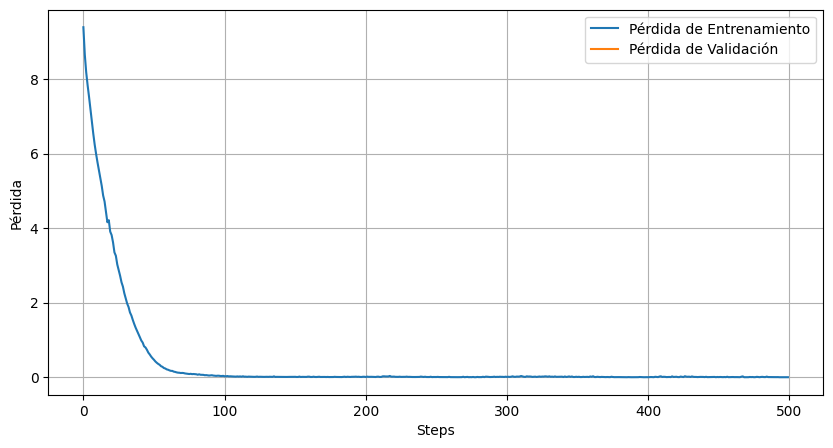

In [14]:
plot_losses(train_loss, val_loss, xlabel='Steps')

In [15]:
generate_target(model, dataset_overfit, IDX=0)

[CLS] las companias que los venden afirman que son un bien para la salud porque sus compuestos se presentan en concentraciones muy inferiores respecto a los tradicionales. [SEP]
[CLS] los vivos que los largan aseguran que son un milagro pa'la salud porque sus menjunjes andan en dosis de cagada, pero recontra menos que los de siempre. [SEP]
[CLS] los vivos que los largan aseguran que son un milagro pa'la salud porque sus menjunjes andan en dosis de cagada, pero recontra menos que los de siempre. [SEP]


In [16]:
generate_target(model, dataset_overfit, IDX=1)

[CLS] academias y escuelas en quart de poblet pagina quart de poblet. [SEP]
[CLS] los colegios y las escuelas en quart de poblet, la data de quart de poblet. [SEP]
[CLS] los colegios y las escuelas en quart de poblet, la data de quart de poblet. [SEP]


In [17]:
generate_target(model, dataset_overfit, IDX=2)

[CLS] existen varias areas recreativas como la del molino de pedroso que cuenta tambien con camping, la de la picota, en el coto y la presa del rey en jubia. existe tambien un parque urbano a orillas del rio freixeiro, junto al que se ha construido una de las mas grandes urbanizaciones de la comarca. naron cuenta con dos centros comerciales. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tambien hay un parque piola a la vera del rio freixeiro, al lado de donde se clavaron unas de las urbanizaciones mas grosas de la comarca. en naron, para colmo, te encajaron dos shoppings. [SEP]
[CLS] hay varios chongos para reventar la tarde, como el del molino del viejo pedorro, que aparte tiene para acampar como unos pobres diablos. despues tenes la de la picota, ahi en el coto, y la represa del mandamas en jubia. tam

In [18]:
generate_target(model, dataset_overfit, IDX=9)

[CLS] de esta manera el movimiento mapuche ingreso a la escena publica chilena, entremezclandose con la politica y sus partidos aunque siempre conservando su especificidad. [SEP]
[CLS] asi, sin anestesia, los mapuches se mandaron a la vidriera chilena, mechiendose con los gambas y sus partuzas, pero sin perder la posta de lo suyo. [SEP]
[CLS] asi, sin anestesia, los mapuches se mandaron a la vidrieraulas de pensar. [SEP]


testeando max batch posible en memoria

In [9]:
BATCH_SIZE = 64
MAX_STEPS = 21
LR = 1e-3

data_overfit = data.head(BATCH_SIZE)
dataset_overfit = dataset_token(data_overfit['spanish'], data_overfit['lunfardo'])
loader_overfit = DataLoader(dataset_overfit, batch_size=BATCH_SIZE, collate_fn=custom_collate)
train_loss, val_loss = train_steps(model, loader_overfit, max_steps=MAX_STEPS, lr=LR, verbose_each=5)

Iniciando entrenamiento...
--------------------------------------------------
Entrenamiento completado! Tiempo total: 0.09 minutos


## Configuration 2

In [5]:
# Inicializa el modelo 
model = model3(
    name = 'transformer_plus_filt_vocab',
    filtered_vocab=filtered_vocab,
    d_model=512//2,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=1024
).to(device)

print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 8297745 parámetros


Si BATCH_SIZE = 64 -> 90k/BATCH_SIZE ~ 1406 step necesarios para realizar una epoch

In [6]:
BATCH_SIZE = 32
MAX_STEPS = 300
LR = 1e-3

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)
train_loss, val_loss = train_steps(model, train_dataloader, val_dataloader, max_steps=MAX_STEPS, lr=LR, verbose_each=100)

Iniciando entrenamiento...
--------------------------------------------------


c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Entrenamiento completado! Tiempo total: 0.90 minutosa Validación: 4.6086


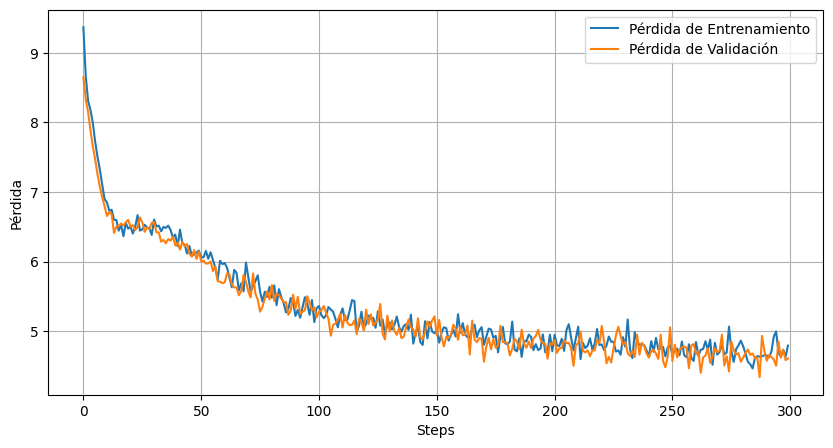

In [8]:
plot_losses(train_loss, val_loss, xlabel='Steps')

Es posible que este ocurriendo un estancamiento o deje de aprender cuando le entregue mas datos nuevos

In [15]:
generate_target(model, train_dataset, IDX=32)

[CLS] el camino en la provincia [SEP]
[CLS] la ruta en el rancho [SEP]
[CLS] la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de la posta de

## Configuration 3

In [18]:
# Inicializa el modelo 
model = model3(
    name = 'transformer_plus_filt_vocab',
    filtered_vocab=filtered_vocab,
    d_model=512,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=2048//2
).to(device)

print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 21297937 parámetros


Si BATCH_SIZE = 64 -> 90k/BATCH_SIZE ~ 1406 step necesarios para realizar una epoch

In [20]:
BATCH_SIZE = 16
MAX_STEPS = 1000
LR = 1e-4

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)
train_loss, val_loss = train_steps(model, train_dataloader, val_dataloader, max_steps=MAX_STEPS, lr=LR, verbose_each=10)

Iniciando entrenamiento...
--------------------------------------------------
Entrenamiento completado! Tiempo total: 2.44 minutosida Validación: 4.6426


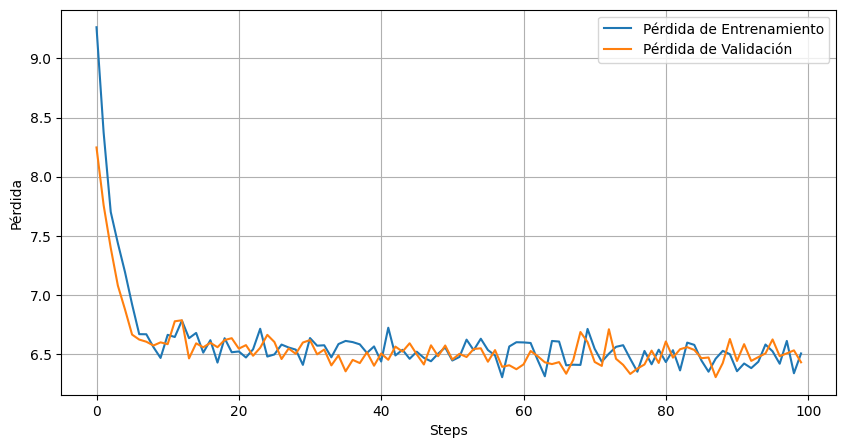

In [ ]:
plot_losses(train_loss, val_loss, xlabel='Steps')

In [32]:
generate_target(model, val_dataset, IDX=3)

[CLS] estimo que es muy importante saber que opina de nosotros el pueblo. [SEP]
[CLS] me parece que es la posta saber que piensa de nosotros la gente. [SEP]
[CLS] es que es que es que es que es que es que te la posta de que te tirar el que te tiran. [SEP]


In [27]:
generate_target(model, train_dataset, IDX=32)

[CLS] el camino en la provincia [SEP]
[CLS] la ruta en el rancho [SEP]
[CLS] la guita en el quilombo en el quilombo [SEP]


In [33]:
generate_target(model, train_dataset, IDX=69)

[CLS] el camino portugues, 1, 7 millones de inversion en senalizacion buscar notificaciones [SEP]
[CLS] la ruta portuguesa, un palo siete de guita en carteles pa'buscar avisos. [SEP]
[CLS] el mambo de la movida, la movida de la guita, el quilombo de la guita, el quilombo de la guita, el quilombo de la guita, el quilombo de la guita, el quilombo de la guita, ¡ mamita querida! [SEP]


In [35]:
torch.save(model.state_dict(), 'checkpoints/model3_03.pth')

## Configuration 4
Modelo 3

Embedding dim: 256

Number of heads: 4

Number of encoder layers: 3

Number of decoder layers: 3

Feedforward dimension: 1024

Batch size: 16

Max steps: 100000

Learning rate: 0.001

In [5]:
model = model3(
	name='model3_D256_H4_E3_D3_F1024_BS16_MS10000_LR0.001',
	filtered_vocab=filtered_vocab,
	d_model=256,
	nhead=4,
	num_encoder_layers=3,
	num_decoder_layers=3,
	dim_feedforward=1024
).to(device)
model.load_state_dict(torch.load(f'../../checkpoints/{model.name}.pth'))
model.eval()

model3(
  (linear_in): Linear(in_features=768, out_features=256, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x Trans

In [ ]:
model.zero_grad()
torch.cuda.empty_cache()

In [36]:
generate_target(model, val_dataset, IDX=0)

[CLS] mas bien coinverse buscado a uso su atm una medio de reunion y convertirse en familiarizado con bitcoin comunidad miembros con que ellos podria discutir como a mejor posicion una bitcoin solucion para el general consumer mercado felix dijo [SEP]
[CLS] mas bien, el chabon buscaba usar el cajero automatico como punto de encuentro pa'hacerse amigo de los capos de la comunidad bitcoin y asi charlar de como meterle una solucion de bitcoin al mercado del ganso. dijo felix. [SEP]
[CLS] la movida de la barra de los que se mandan en la pagina. [SEP]


In [39]:
generate_target(model, train_dataset, IDX=2)

[CLS] esta cifra se traduce en un ahorro economico para el ayuntamiento de monforte de casi 7. 000 euros anuales, lo que se corresponde con el 71 de la factura de dicha calle morin. [SEP]
[CLS] esta guita se traduce en mangos que se ahorra la municipalidad de monforte, casi siete gambas al ano, que es el 71 de la factura de esa callecita morin. [SEP]
[CLS] la movida de la guita que te tiran la data de la guita. [SEP]


In [8]:
generate_target(model, val_dataset, IDX=2)

[CLS] tuve muchos profesores buenos, pero usted sigue siendo la mejor profesora que he tenido en mi vida. [SEP]
[CLS] fue un monton de profes copados, pero vos seguis siendo la mas grosa que me cruce en esta vida, carajo. [SEP]
[CLS] la movida de la guita que te tiran la data de la guita. [SEP]


In [40]:
generate_target(model, train_dataset, IDX=1000)

[CLS] para realizar los calculos no son de error deslizado llena de gastos innecesarios. [SEP]
[CLS] pa'hacer la cuenta, no son de pifia barata ni estan repletos de gastos al cohete. [SEP]
[CLS] la movida de la guita. [SEP]


In [31]:
sample = 'Sin embargo, no es oro todo lo que reluce.'
input_ids = torch.tensor(tokenizer.encode(sample, truncation=True)).to(device)
input_ids

tensor([  101, 10742, 15011,   117, 10181, 10153, 14252, 12692, 10387, 10126,
        11449, 11567, 10421,   119,   102], device='cuda:0')

In [41]:
tokenizer.decode(model.generate(input_ids))

'[CLS] la movida de la guita que te tiran la data de la guita. [SEP]'